# Clustering on protein assemblies shape
Goal of this notebook is using TDA featurization of protein assemblies to group them according to their topological shape.  
We start with a brief data analysis of TDA featurized proteins, we then use this information to detect proteins that are connected and have interesting shape by forcing conditions based on landcapes encoding.
Next step is defining a distance between featurized proteins: this is done by considering L1-distance between landscape i=1,2,3 in dimension j=1,2 and then by aggregating at dimension level by an arithmetic mean.
In this we define a distance between dim j landscapes. This two distances (dim 1 and dim 2) are then computed for any pair of proteins and fed to HDBSCAN algorithm to cluster proteins according to their shapes. As last step we group proteins having similar landscapes in dimension 1 and 2 by checking which proteins are put in the same cluster according toboth dim 1 and dim 2 similarity.

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time
import random

from constants import plots3d_path
from data_analysis_utils.utils import define_features_var_grouping, check_features_distribution
from data_analysis_utils.proteins_similarity import compute_landscapes_l1_distance, pairwise_l1_dist_dim, get_discrete_pair_sim, convert_clustering_matrix_to_df
from data_analysis_utils.visualization import apply_mds, compare_pdb_plots
from data_analysis_utils.tda_utils import interesting_homology_filter
from clustering import cluster_data, analyze_cluster

### Load data 

Load encoded protein assemblies comprising at least three distinct protein subunits. These are indexed by pdb_id.  
For convenience you can download the vectorized proteins (named 'tda_encoded_proteins_assembly.csv'), as well as their obtained persistence diagrams and landscapes from [here](https://drive.google.com/drive/folders/1Y1qFJvhtq4VUSEV7cY4jjYMyb_AfFEMX) and move them in 'output' directory of your cloned git project.

In [3]:
df = pd.read_csv('output/tda_encoded_proteins_assembly.csv')
df = shuffle(df, random_state=17).reset_index(drop=True)
df.shape

(14183, 84)

<ins>Featurization details</ins>:  
- *dim 0:* take five largest finite end points of the 0-dimensional bars (note there are as many bars as atoms and one of them has infinite length since one connected component lasts forever)  
- *dim 1:* each landscape is approximated by an order 5 Fourier series along with landscape start and end point. we restrict to the first three landscapes.  
- *dim 2:* each landscape is approximated by an order 5 Fourier series along with landscape start and end point. we restrict to the first three landscapes.

Dimension 0 encoding requires 5 variables, while dimensions 1 and 2 require *num_landscapes \* (num coeff Fourier order 5 + num start/end point)  =3 \* (11 + 2) = 39*  each. In total each protein is encoded by 83 = (39 \* 2) + 5 variables.


### Data analysis 

In [4]:
df.head()

,end_dim0_4,end_dim0_3,end_dim0_2,end_dim0_1,end_dim0_0,begin0_dim1,end0_dim1,a00_dim1,a10_dim1,b10_dim1,...,b12_dim2,a22_dim2,b22_dim2,a32_dim2,b32_dim2,a42_dim2,b42_dim2,a52_dim2,b52_dim2,pdb_id
0,0.016653,0.016829,0.017497,0.018127,0.020563,0.008818,2.287163,0.397747,0.008854,0.212187,...,-0.001136,-0.015003,0.015701,0.013206,-0.006437,-0.023021,-0.014598,-0.011707,0.013695,5N60
1,0.013948,0.018293,0.018507,0.019814,0.020948,0.015655,0.322974,0.116917,-0.042125,0.051454,...,-0.003463,-0.003617,-0.012425,-0.003859,0.003016,0.001733,-0.000613,-0.001436,-0.000055,1OED
2,0.028250,0.028999,0.029191,0.029231,0.033350,0.005733,0.924789,0.010331,0.006648,0.005211,...,0.007018,-0.000143,-0.006174,0.001364,0.001377,-0.002091,-0.000105,0.001839,0.001000,4AC7
3,0.017916,0.018095,0.018544,0.018621,0.991182,0.514619,3.548179,1.570846,-0.679233,-0.455567,...,-0.000155,-0.020321,0.010022,0.014369,-0.002203,-0.001113,-0.011260,-0.001214,0.006310,6QV0
4,0.043156,0.055253,0.056881,0.101645,0.138809,0.068090,2.583287,0.718226,-0.116782,0.383141,...,0.001824,0.002775,0.002837,0.001003,0.003037,-0.000466,0.002592,-0.001430,0.002117,4UJ3


In [5]:
df.describe()

,end_dim0_4,end_dim0_3,end_dim0_2,end_dim0_1,end_dim0_0,begin0_dim1,end0_dim1,a00_dim1,a10_dim1,b10_dim1,...,a12_dim2,b12_dim2,a22_dim2,b22_dim2,a32_dim2,b32_dim2,a42_dim2,b42_dim2,a52_dim2,b52_dim2
count,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,...,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000,14183.000000
mean,0.025872,0.027426,0.029586,0.033930,0.243241,0.024021,1.114969,0.213613,-0.050447,0.025080,...,-0.010251,-0.005071,-0.006930,0.000466,-0.001685,-0.000217,-0.000931,-0.000278,-0.000938,-0.000216
std,0.022489,0.029001,0.035468,0.055595,19.818749,0.278046,1.982165,0.488506,0.187288,0.086309,...,0.033438,0.062500,0.023607,0.015265,0.008634,0.007693,0.005828,0.004995,0.004821,0.004034
min,0.005795,0.005803,0.005890,0.006370,0.008128,0.000000,0.000000,0.000000,-4.586813,-1.995163,...,-0.960102,-0.989815,-0.533003,-0.412811,-0.287266,-0.171036,-0.195719,-0.081239,-0.095696,-0.056386
25%,0.016128,0.016876,0.017779,0.018953,0.021449,0.006098,0.332463,0.038857,-0.046097,0.005025,...,-0.013284,0.000025,-0.006712,-0.004373,-0.003039,-0.002594,-0.001746,-0.001580,-0.001375,-0.001071
50%,0.024674,0.025382,0.026381,0.027948,0.030874,0.008591,0.599700,0.082951,-0.003535,0.017955,...,-0.008626,0.006325,-0.002675,-0.000637,-0.000666,-0.000423,-0.000296,-0.000080,-0.000236,0.000002
75%,0.030841,0.032073,0.033780,0.036581,0.043545,0.016001,1.268246,0.174841,0.012175,0.042971,...,-0.000931,0.010352,0.001060,0.002848,0.001157,0.001445,0.000914,0.001094,0.000635,0.000936
max,1.037337,1.774901,2.283025,3.072257,2358.293495,20.255440,61.542136,12.075035,0.728428,2.014654,...,0.295423,0.194277,0.140664,0.212047,0.103101,0.142805,0.073979,0.143995,0.094906,0.088954


It can be very convenient to aggregate variables into groups of high level features having some intuitive iterpretation. 

In [6]:
# Group together variables used to encode:
# - landscape 1/2/3 in dimension 1/2,
# - 0-dimensional landscapes
# - etc...
grouped_feat_var = define_features_var_grouping(df)
grouped_feat_var.keys()

dict_keys(['feat_cols', 'feat_cols_dim0', 'feat_cols_begin_end', 'features_var_dict_dim_land_shape_extrema', 'features_var_dict_dim_land', 'features_var_dict_dim'])

dim0


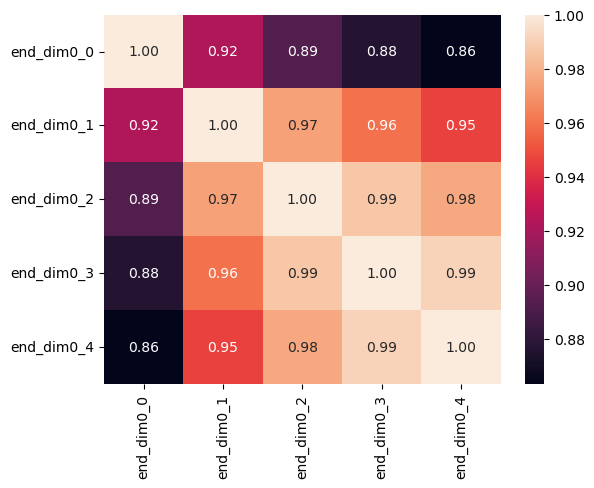

dim1_land1


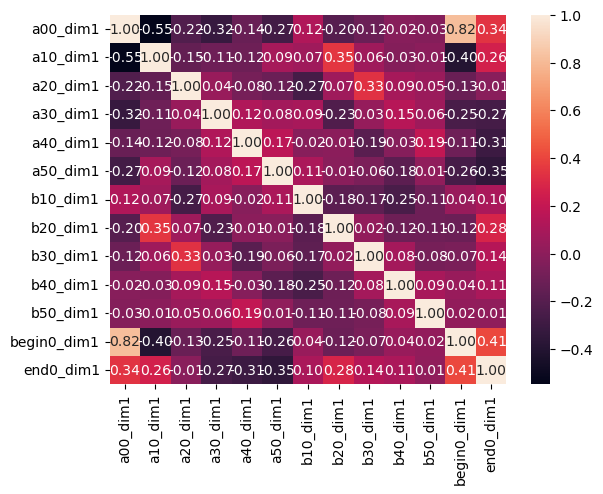

dim1_land2


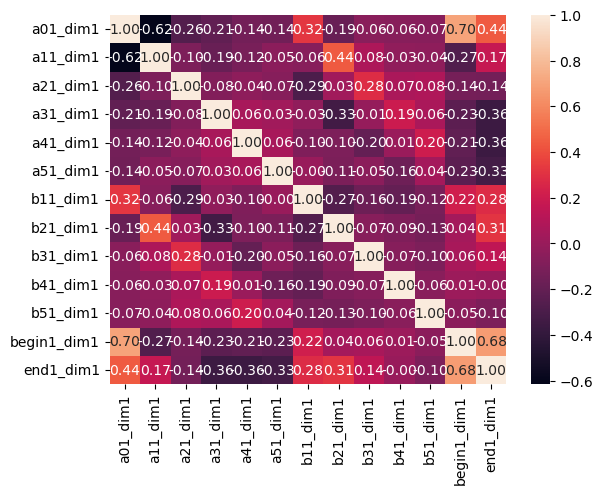

dim1_land3


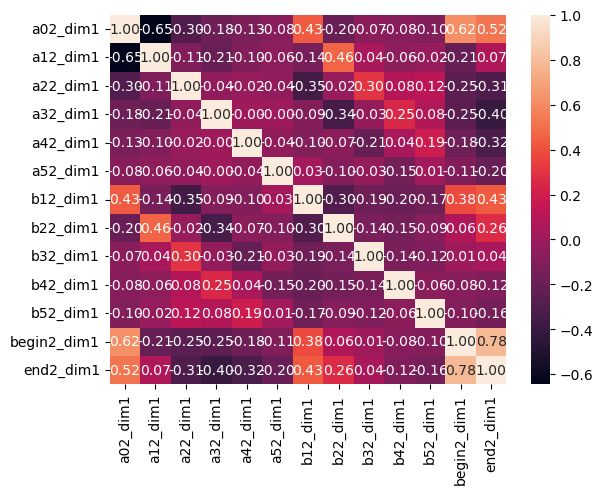

dim2_land1


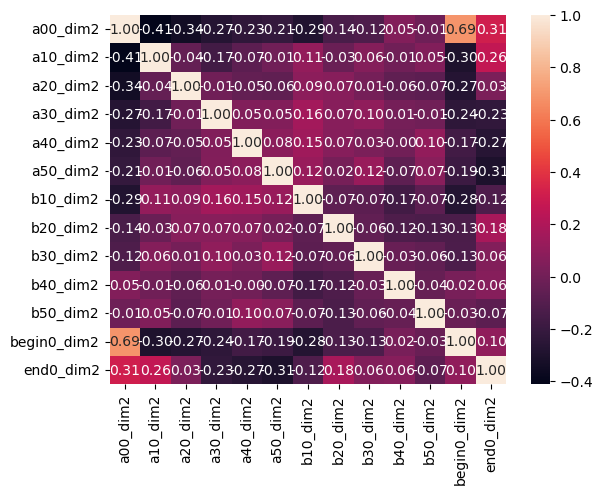

dim2_land2


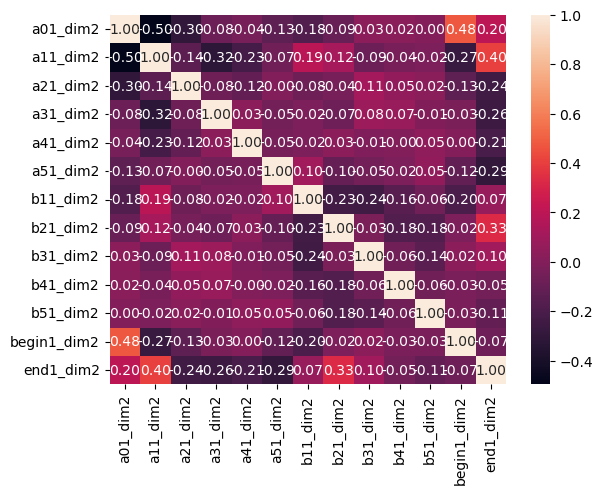

dim2_land3


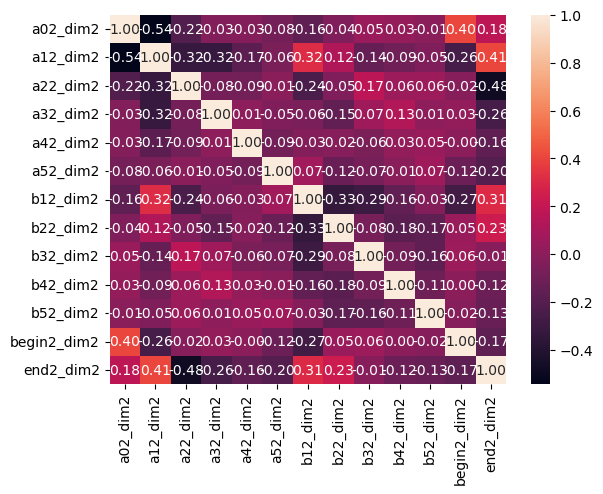

In [7]:
# Check correlation among group of features
for key in grouped_feat_var['features_var_dict_dim_land'].keys():
    df_corr = df[np.sort(grouped_feat_var['features_var_dict_dim_land'][key])].corr('spearman')
    sns.heatmap(df_corr, annot = True, fmt = '.2f')
    print(key)
    plt.show()

Considerations:
 - begin_dim1 and end_dim1 are correlated, while Fourier coefficients are not (makes sense)
 - a10 is bigger than b10 for first landscape since for the approximated function we have f(0)=0 like sin, 
 - dim 0 features are very correlated, what about taking only 0, 2 and 4?

dim0


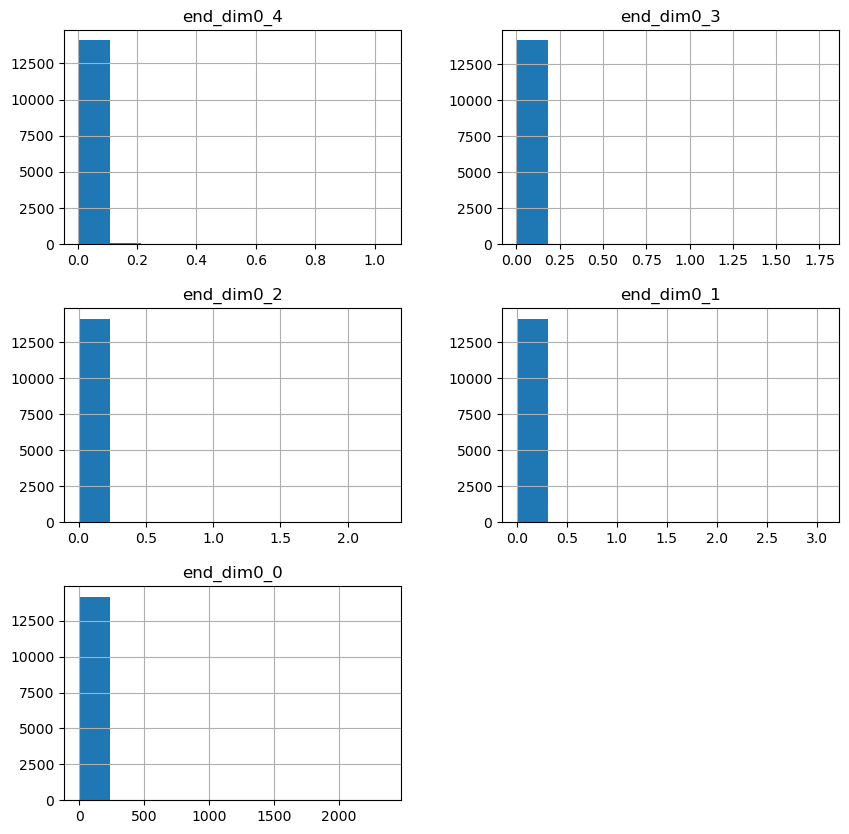

dim1_land1


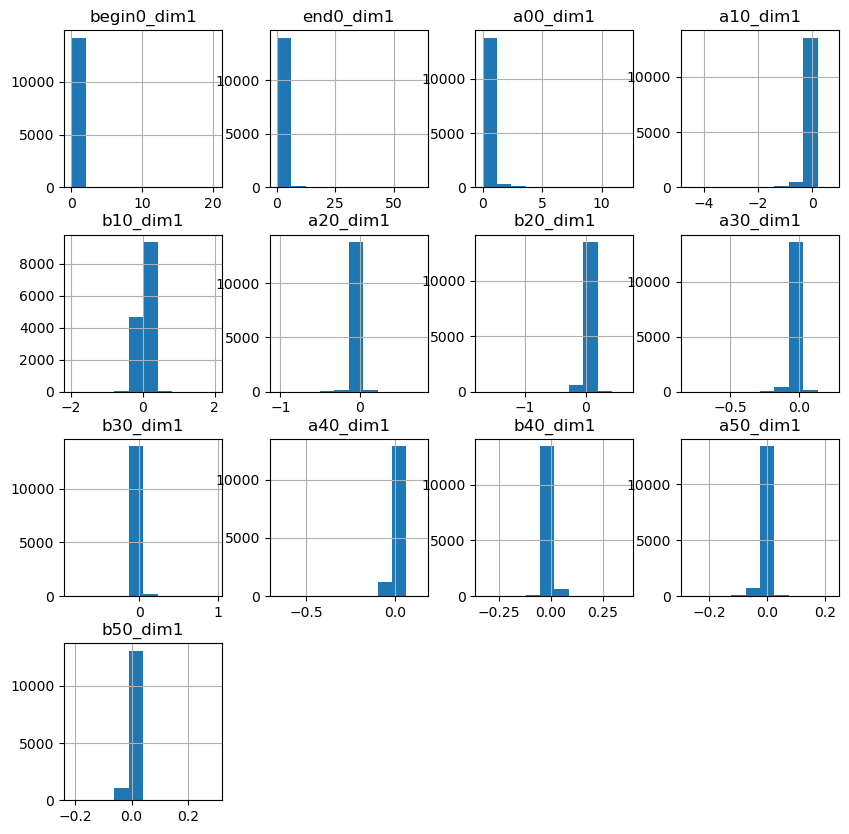

dim1_land2


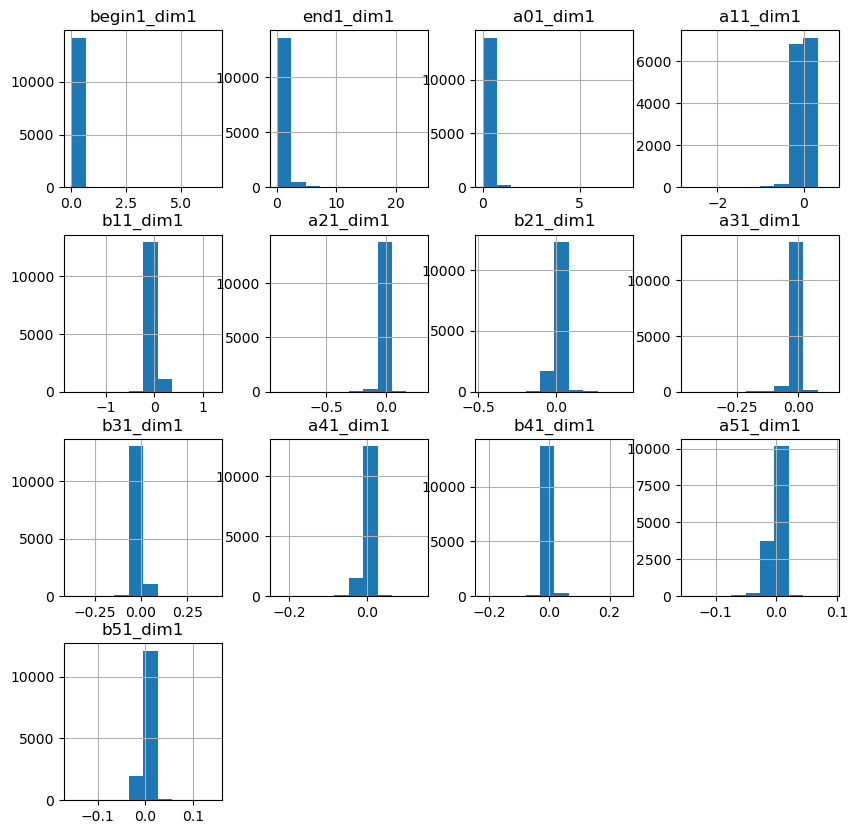

dim1_land3


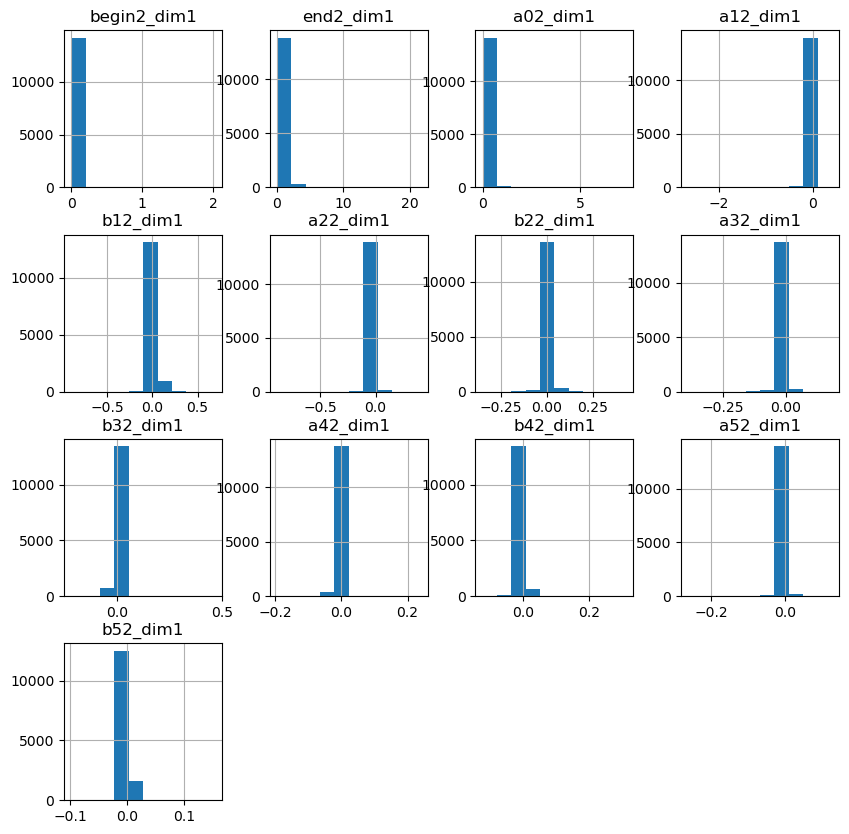

dim2_land1


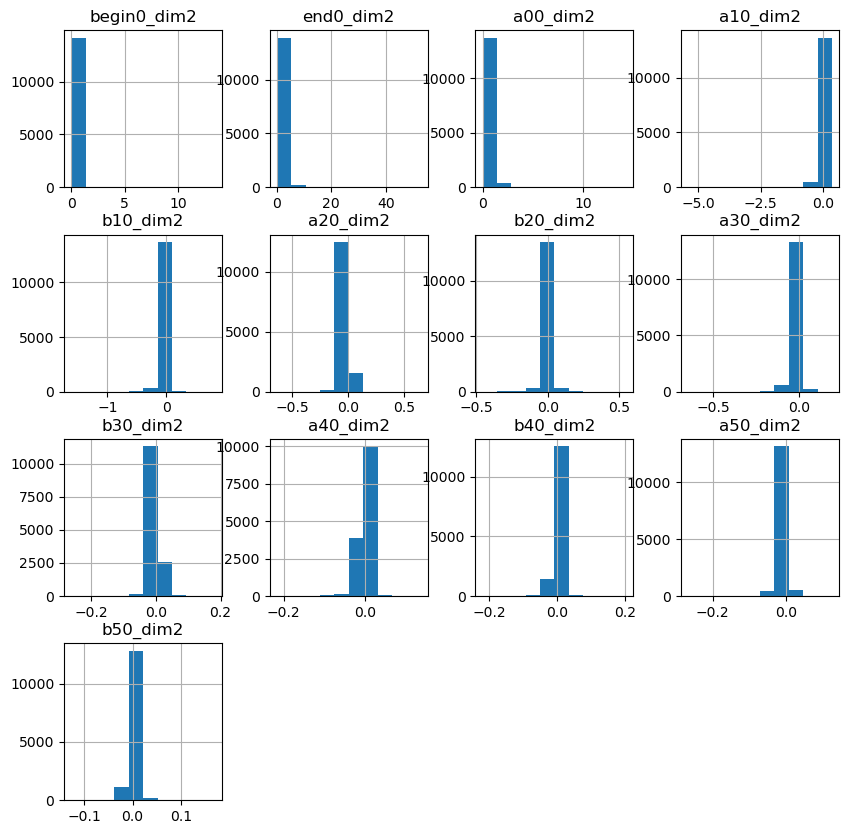

dim2_land2


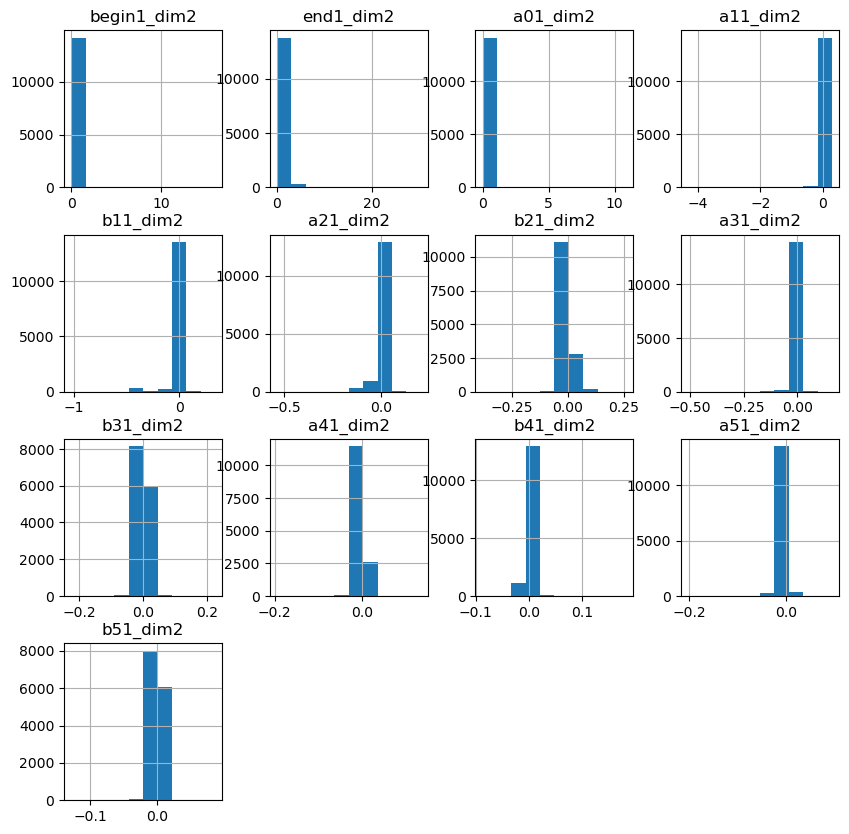

dim2_land3


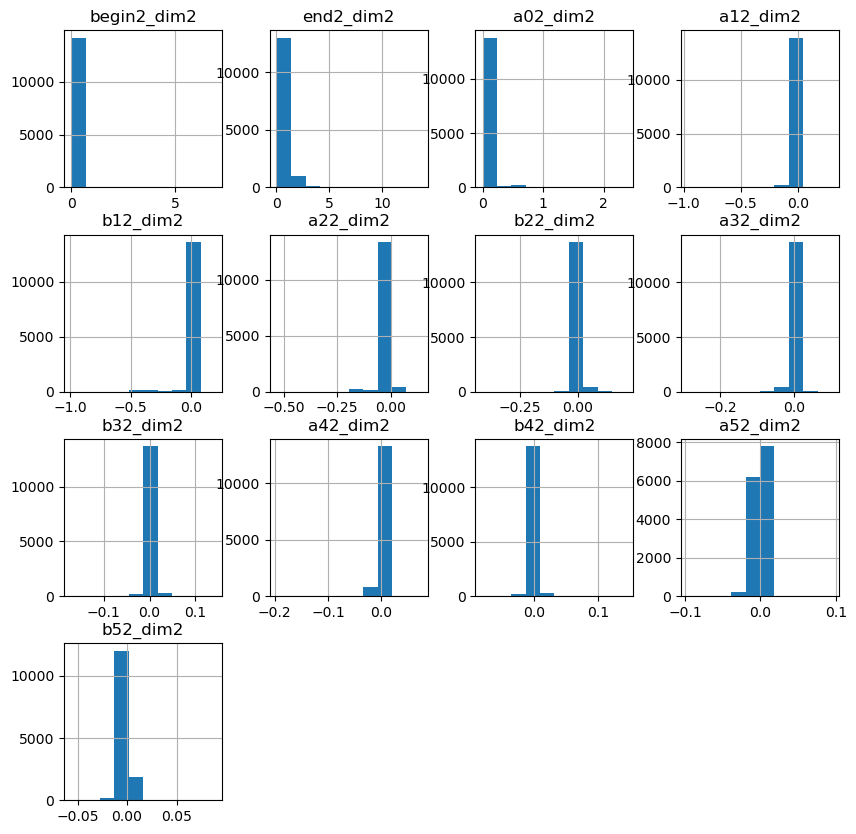

In [8]:
# Check features distribution
check_features_distribution(df, grouped_feat_var['features_var_dict_dim_land'])

Considerations:
 - some proteins have huge values of end_dim00, hinting to multiple connected components

Let's look for proteins having one single connected component and non-trivial homology in dim 1 and 2.

In [9]:
# Restrict to proteins that should have one single connected component (condition on 0-dim landscape) and 'interesting' 1 and 2 dim homology (conditions on a00_dim1 and a00_dim2, observe that a00_dim_i is the L^2 area under landscape 1 in dimension i)  
df_fun_homology = interesting_homology_filter(df_tda_enc=df)

In [10]:
df_fun_homology.head(5)

,end_dim0_4,end_dim0_3,end_dim0_2,end_dim0_1,end_dim0_0,begin0_dim1,end0_dim1,a00_dim1,a10_dim1,b10_dim1,...,a22_dim2,b22_dim2,a32_dim2,b32_dim2,a42_dim2,b42_dim2,a52_dim2,b52_dim2,pdb_id,connected
3,0.017916,0.018095,0.018544,0.018621,0.991182,0.514619,3.548179,1.570846,-0.679233,-0.455567,...,-0.020321,0.010022,0.014369,-0.002203,-0.001113,-0.011260,-0.001214,0.006310,6QV0,True
4,0.043156,0.055253,0.056881,0.101645,0.138809,0.068090,2.583287,0.718226,-0.116782,0.383141,...,0.002775,0.002837,0.001003,0.003037,-0.000466,0.002592,-0.001430,0.002117,4UJ3,True
27,0.039752,0.040713,0.040733,0.042999,0.047130,0.006684,1.156513,0.034957,0.013616,0.020405,...,-0.135409,0.068071,0.005415,0.009339,0.006442,-0.006946,-0.025434,-0.008816,6HW7,True
39,0.035075,0.036422,0.041543,0.049431,0.088805,0.027814,1.321536,0.174137,0.019373,0.136643,...,-0.018657,-0.015348,-0.023411,0.019539,-0.000504,0.005626,-0.004101,0.008132,3PUF,True
56,0.042058,0.043229,0.043307,0.043333,0.061980,0.054388,1.309279,0.934618,-0.376371,-0.014186,...,0.000687,-0.002714,0.003596,0.000187,-0.001303,-0.000038,-0.000847,-0.001138,6VZR,True


#### Compute pairwise distance

Get pairwise distances between proteins. 
You can either compute them from scratch (takes some time) or load the precomputed distance matrices you can find [here](https://drive.google.com/drive/folders/1IKT6VsSz0nQnEkHMS9Ibz7akOBefgIf5) (you should put them in directory 'output/pairwise_dist_pdb' of your cloned git project).

In [11]:
load_precomputed_distances = True

if load_precomputed_distances:
    # Load precomputed pairwise distances (this is done only for a subset of 400 proteins, need to do for more)
    pairwise_l1_dist_dim1_dict = {}
    pairwise_l1_dist_dim2_dict = {}
    pairwise_l1_dist_dim1_dict['dim1_land1'] = pd.read_csv('output/pairwise_dist_pdb/pairwise_dist_dim1_land1_400pdb.csv',index_col=0)
    pairwise_l1_dist_dim1_dict['dim1_land2'] = pd.read_csv('output/pairwise_dist_pdb/pairwise_dist_dim1_land2_400pdb.csv',index_col=0)
    pairwise_l1_dist_dim1_dict['dim1_land3'] = pd.read_csv('output/pairwise_dist_pdb/pairwise_dist_dim1_land3_400pdb.csv',index_col=0)
    pairwise_l1_dist_dim2_dict['dim2_land1'] = pd.read_csv('output/pairwise_dist_pdb/pairwise_dist_dim2_land1_400pdb.csv',index_col=0)
    pairwise_l1_dist_dim2_dict['dim2_land2'] = pd.read_csv('output/pairwise_dist_pdb/pairwise_dist_dim2_land2_400pdb.csv',index_col=0)
    pairwise_l1_dist_dim2_dict['dim2_land3'] = pd.read_csv('output/pairwise_dist_pdb/pairwise_dist_dim2_land3_400pdb.csv',index_col=0)
else:
    # Get distance between dim 1 landscapes (rmk: as example, to save time this is done only for a subset of 200 proteins, need to do for more)
    start = time.time()
    pairwise_l1_dist_dim1_dict = pairwise_l1_dist_dim(df=df_fun_homology.head(200), dim='1',grouped_feat_var=grouped_feat_var)
    end = time.time()
    print(f'time: {end - start} s')
    # Get distance between dim 2 landscapes
    start = time.time()
    pairwise_l1_dist_dim2_dict = pairwise_l1_dist_dim(df=df_fun_homology.head(400), dim='2',grouped_feat_var=grouped_feat_var)
    end = time.time()
    print(f'time: {end - start} s')

In [12]:
# Aggregate dim i land j distances to a single dim i distance
df_pair_l1dist_dim1 = 1/3*(pairwise_l1_dist_dim1_dict['dim1_land1'] + pairwise_l1_dist_dim1_dict['dim1_land2'] + pairwise_l1_dist_dim1_dict['dim1_land3'])
df_pair_l1dist_dim2 = 1/3*(pairwise_l1_dist_dim2_dict['dim2_land1'] + pairwise_l1_dist_dim2_dict['dim2_land2'] + pairwise_l1_dist_dim2_dict['dim2_land3'])

### Clustering 

In [13]:
# Cluster proteins according to 1-dimensional landscapes 
df_cluster_dim1 = cluster_data(df_pair_l1dist_dim1, min_cluster_size=2)

clusters size
label
 28      154
-1        97
 21       14
 8         8
 14        7
 22        7
 24        6
 27        6
 29        6
 16        5
 4         5
 30        5
 11        5
 13        5
 33        5
 32        4
 20        4
 34        4
 1         4
 2         4
 12        4
 10        4
 0         3
 18        3
 31        3
 3         3
 6         3
 26        3
 25        3
 9         3
 15        3
 7         2
 5         2
 23        2
 19        2
 17        2
Name: count, dtype: int64


In [14]:
# Cluster proteins according to 2-dimensional landscapes 
df_cluster_dim2 = cluster_data(df_pair_l1dist_dim2, min_cluster_size=2)

clusters size
label
 2       134
-1       127
 23       39
 15       14
 14       14
 13        7
 0         5
 1         5
 7         5
 9         5
 22        4
 24        4
 8         4
 3         4
 16        3
 17        3
 21        3
 4         3
 12        3
 11        2
 10        2
 6         2
 5         2
 18        2
 19        2
 20        2
Name: count, dtype: int64


In [15]:
# Represent clusters as incidence matrices (a_ij is 1 if protein i is in same cluster as protein j and 0 otherwise) 
df_pair_sim_disc_dim1 = get_discrete_pair_sim(df_cluster_dim1)
df_pair_sim_disc_dim2 = get_discrete_pair_sim(df_cluster_dim2)

In [16]:
# Sum incidence matrices for dim 1 and dim 2 clusters to get a matrix whose entries a_ij are either:
# - 0 if protein i and j belongs do different clusters in dim 1 and dim 2 
# - 1 if protein i and j belongs to same cluster in dim 1 or (XOR) in dim 2 
# - 2 if protein i and j belongs to same cluster in dim 1 and dim 2 
df_pair_sim_disc = df_pair_sim_disc_dim1 + df_pair_sim_disc_dim2  

In [17]:
# Go back from matrix representation to df representation in which one column is cluster label and the other is the list of elements belonging to cluster
df_cluster = convert_clustering_matrix_to_df(df_pair_sim_disc).reset_index(drop=True)

In [18]:
df_cluster.head(10)

,label,cluster,num_el
0,9,"[1RYP, 3D29, 3E47, 3GPJ, 3HYE, 3MG7, 3OEU, 4FZ...",134
1,40,"[3ZRC, 4BKS, 4W9C, 4W9D, 4W9G, 4W9H, 4W9I, 4W9...",13
2,188,"[7TK1, 7TK2, 7TK5, 7TKC, 7TKD, 7TKF]",6
3,41,"[3ZRF, 3ZUN, 4W9F, 6VZR]",4
4,37,"[3UNF, 5LEY, 5LF0, 5LF7]",4
5,56,"[4NGE, 5NJ9, 5NJA, 5NJF]",4
6,22,"[2WSC, 2WSE, 2WSF]",3
7,24,"[3A1J, 3G65, 5NKM]",3
8,59,"[4TUJ, 5DMG, 5JMO]",3
9,2,"[1EZV, 3RIF, 5W23]",3


In [19]:
# Pick a sample cluster
ex_label = 56
ex_cluster = list(df_cluster[df_cluster['label']==ex_label]['cluster'].values[0])
ex_cluster

['4NGE', '5NJ9', '5NJA', '5NJF']

4NGE


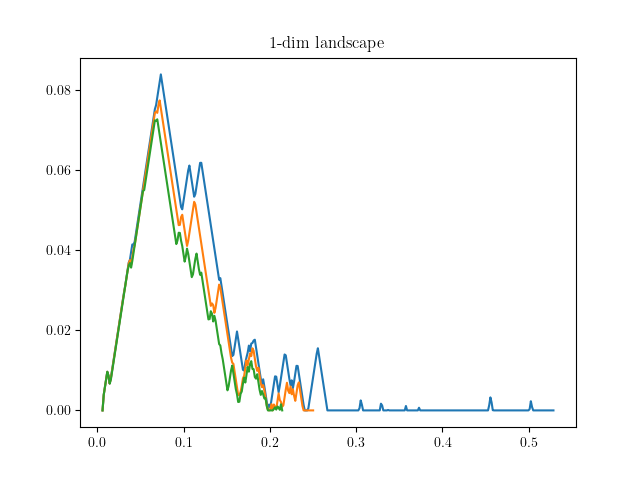

5NJ9


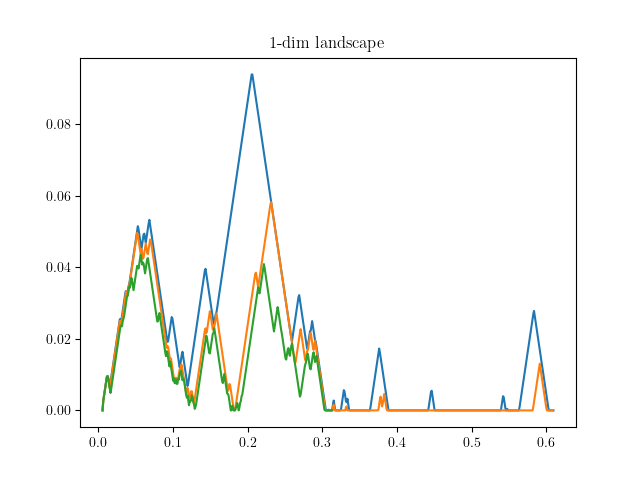

5NJA


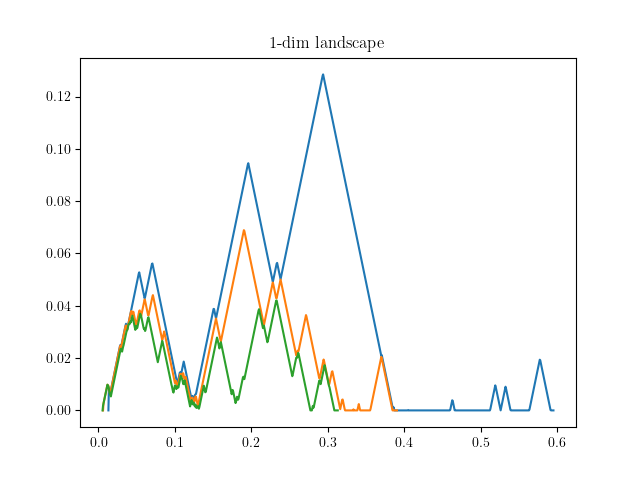

5NJF


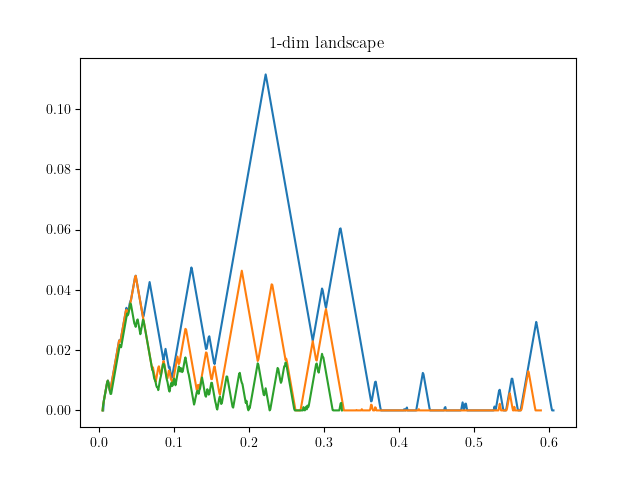

4NGE


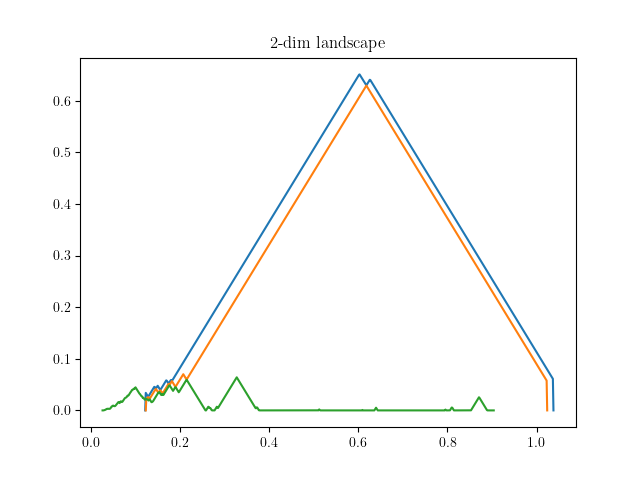

5NJ9


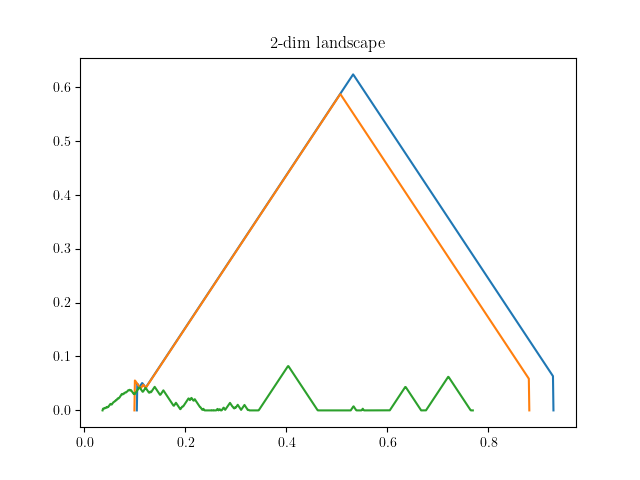

5NJA


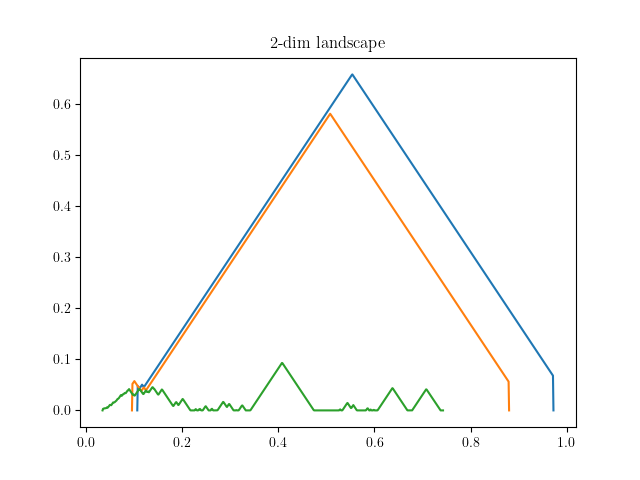

5NJF


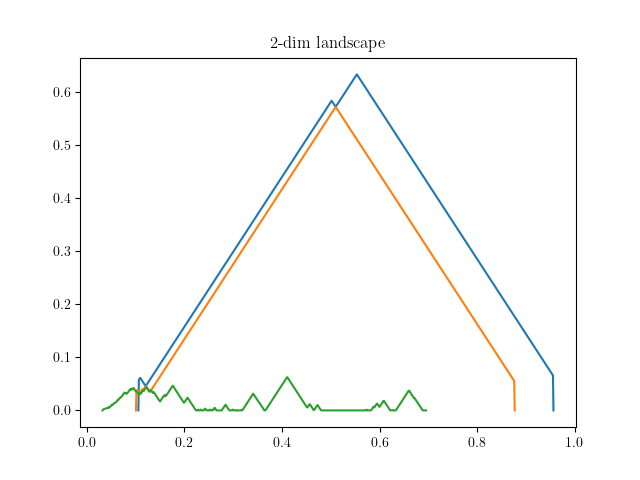

In [20]:
# Do visual comparison of landscapes and proteins 3d structure
analyze_cluster(pdb_ids=ex_cluster, display_rcbs_web=True)

### Conclusion
Clustering procedure on TDA encoded proteins results in creating groups of proteins having similar topogical shape. This is confirmed visually by inspecting protein 3d structure on RCBS website.